# DAT565/DIT407 Assignment 2

Author: Group 26 | Wenjun Tian wenjunt@chalmers.se | Yifan Tang yifant@chalmers.se

Date: 2024-11-15

# Problem 1: Scraping house prices

Problem 1 requires us to extract house price data from `HTML` files and convert it into a `CSV` file.

The following piece of code extracts house price data from a single `HTML` file and convert it into a `DataFrame` data structure which is a pivot table for all the advertisements. The table structure is shown below:

| Date of sale (dd-m-yyyy) | Address           | Location            | Area (m^2) | No. of rooms | Area of the plot (m^2) | Closing price (kr) |
| :----------------------- | :---------------- | :------------------ | :--------- | :----------- | :--------------------- | :----------------- |
| 22-Jun-2022              | Halltorpsvägen 11 | Kode,Kungälvskommun | 107+13     | 4            | 1119                   | 4800000            |


The general idea is to use `BeautifulSoup` to locate `HTML` elements, such as `div` or `span`, and process those `HTML` element strings to find out data that we concern about.

Code and detailed description is as follows:

In [2]:
import pandas as pd
from bs4 import BeautifulSoup

# convert Swedish months to English
map_swe_month_to_eng_abbr = {
    "januari": "Jan",
    "februari": "Feb",
    "mars": "Mar",
    "april": "Apr",
    "maj": "May",
    "juni": "Jun",
    "juli": "Jul",
    "augusti": "Aug",
    "september": "Sep",
    "oktober": "Oct",
    "november": "Nov",
    "december": "Dec"
}

'''
description: uniformize date to format like "10-Feb-2021".
param {str} s: raw date
return {str} formated date
'''
def uniformize_date(s: str) -> str:
    # If date formatted like: "10-Feb-21", and month is in English
    if " " not in s: 
        i = s.rfind('-')
        return s[: i + 1] + "20" + s[i + 1: ]
    # If date formatted like: "23 mars 2023", and month is in Swedish
    else:
        ss = s.split(" ")
        return '-'.join([ss[0], map_swe_month_to_eng_abbr[ss[1]], ss[2]])

'''
description: scrape advertisements from a single html
param {str} path of the html file
return {pd.DataFrame} a pivot table of advertisements
'''
def extract_df_from_html(path: str) -> pd.DataFrame:
    # Reading the HTML File
    with open(path, 'r') as f:
        html = f.read()
    
    # Parsing the HTML    
    soup = BeautifulSoup(html, 'html.parser') 
    
    # List of series. Each series represent attributes of an advertisement
    ad_s_list = list()   

    #iterate all advertisements
    for cell in soup.find_all('li',class_='sold-results__normal-hit'):
        #store attributes of an ad in key-value style
        ad_dict = {}

        # scrape "Date of sale"
        raw_date = cell.find("span", class_="hcl-label hcl-label--state hcl-label--sold-at").text.strip().replace("Såld ", "")
        ad_dict["Date of sale (dd-m-yyyy)"] = uniformize_date(raw_date)

        # scrape "Address"
        ad_dict["Address"] = cell.find("h2", class_="sold-property-listing__heading qa-selling-price-title hcl-card__title").text.strip()

        # Scrape "Location"
        ad_dict["Location"] = cell.find("div", class_="sold-property-listing__location").div.find_all(string=True, recursive=False)[1].replace(' ', '').replace('\n', '')

        # Scrape "Area" and "Number of rooms"
        area_and_rum = cell.find("div", class_="sold-property-listing__subheading sold-property-listing__area").text.replace(' ', '').replace('\n', '').split("\u00A0")
        # variable "area_and_rum" is formatted like: ['161+55', 'm²', '5', 'rum']
        # sometimes one of the attributes is not available. We fill the missing value with "NaN"
        ad_dict["Area (m^2)"] = area_and_rum[area_and_rum.index('m²') - 1] if 'm²' in area_and_rum else 'NaN'
        ad_dict["No. of rooms"] = area_and_rum[area_and_rum.index('rum') - 1] if 'rum' in area_and_rum else 'NaN'

        # scrape "Area of the plot
        land_area_element = cell.find("div", class_="sold-property-listing__land-area")
        ad_dict["Area of the plot (m^2)"] = land_area_element.text.replace(" ", '').replace('\n', '').replace('\xa0', '')[: -6:] if land_area_element != None else "NaN"

        # scrape "Closing price"
        index_of_slutpris = cell.text.find("Slutpris")
        ad_dict["Closing price (kr)"] = cell.text[index_of_slutpris + len("Slutpris"): cell.text.find("kr", index_of_slutpris): ].replace(" ", '').replace("\u00A0", '')

        # convert the dict to a series
        ad_s = pd.Series(ad_dict)

        # add this advertisement series to list
        ad_s_list.append(ad_s)
        
    #combine advertisement series into a single dataframe 
    #each series is a row of the pivot table
    df = pd.concat(ad_s_list, axis = 1) 
    return df.T

The following piece of code combines data scraped from different `HTML` files into a single `DataFrame`, and then write it to a `CSV` file. The first 5 rows of the data are shown as the result of this code block.

In [4]:
import os
# path to html file directory
DATA_DIR = "./kungalv_slutpriser"

# list of advertisement dataframes scraped from single html files
df_list = []

#iterate all html files, scrape and add dataframe to the list
for root, _, files in os.walk(DATA_DIR):
    for f in files:
        df = extract_df_from_html(os.path.join(root, f))
        df_list.append(df)

# combine dataframes scraped from single html files
data = pd.concat(df_list)

# show the first 3 rows of the data
print(data.head(3))

# write dataframe to csv file. Encoding with UTF-8 character set since there are swedish characters.
data.to_csv("data.csv", index=None, encoding="UTF-8")

  Date of sale (dd-m-yyyy)                  Address  \
0              10-Feb-2021              Guddeby 174   
1               9-Feb-2021  Gamla Trollhättevägen 6   
2               8-Feb-2021               Lybeck 151   

                         Location Area (m^2) No. of rooms  \
0  Ytterby/Guddeby,Kungälvskommun        143            6   
1         Centralt,Kungälvskommun    210+170            8   
2          Diseröd,Kungälvskommun     117+40            4   

  Area of the plot (m^2) Closing price (kr)  
0                   1257            5475000  
1                   1368            7600000  
2                   1572            5120000  


# Problem 2: Analyzing 2022 house sales

## 2.1 Five number summary

Extracting the last four characters as the year value and check if it's equal to `2022`. Then calculate the maximum value, minimum value, median, the lower quantile and the upper quantile.

In [6]:
# read csv file
data = pd.read_csv('data.csv')

# # only data from 2022 is retained
data = data[data['Date of sale (dd-m-yyyy)'].apply(lambda x: x[-4:]) == '2022'] 

# if data.empty:
#     print("Data for 2022 is not available.")

# get closing prices
closing_prices = data['Closing price (kr)']

# calculate five number summary
minimum = closing_prices.min()
maximum = closing_prices.max()
median = closing_prices.median()
q1 = closing_prices.quantile(0.25)
q3 = closing_prices.quantile(0.75)

print(f"Minimum: {minimum}")
print(f"Lower quartile: {q1}")
print(f"Median: {median}")
print(f"Upper quartile: {q3}")
print(f"Maximum: {maximum}")


Minimum: 1650000
Lower quartile: 4012500.0
Median: 5000000.0
Upper quartile: 5795000.0
Maximum: 10500000


## 2.2 plot histogram of the closing prices

The Freedman-Diaconis rule is a statistical method used to determine the optimal bin width for a histogram. This rule is designed to create a histogram that balances the detail (number of bins) and the overall representation of data. The formula for calculating the bin width is:

$$
BinWidth = \frac {2 \times IQR}{N ^ {\frac {1}{3} }}
$$

For this formula:
IQR (Interquartile Range): Represents the difference between the upper quartile and the lower quartile. 
N: The total number in the dataset.

After calculating the bin width, we plot the histogram.


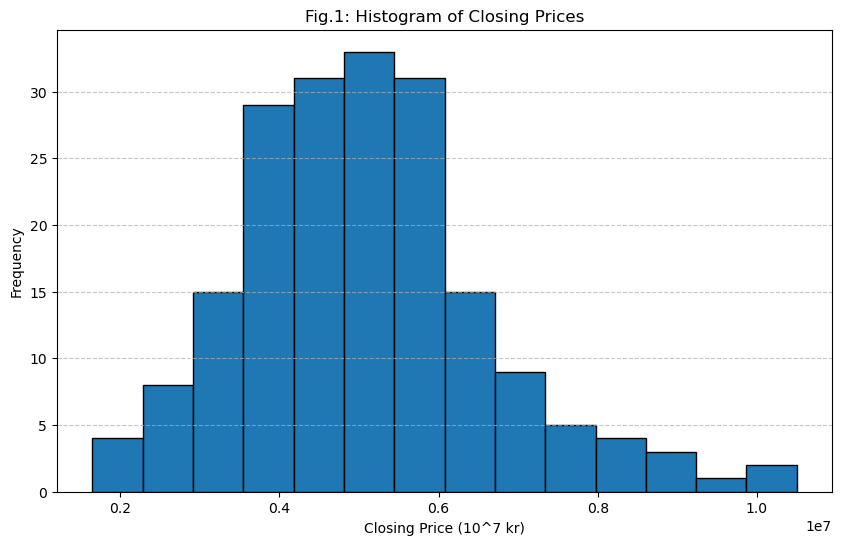

In [10]:
import matplotlib.pyplot as plt

# Freedman-Diaconis
iqr = q3 - q1
bin_width = 2 * iqr / (len(closing_prices) ** (1/3))
num_bins = int((closing_prices.max() - closing_prices.min()) / bin_width)

# print(f"bin = {num_bins}")

plt.figure(figsize=(10, 6))
plt.hist(closing_prices, bins=num_bins, edgecolor='black')
plt.xlabel('Closing Price (10^7 kr)')
plt.ylabel('Frequency')
plt.title('Fig.1: Histogram of Closing Prices')
plt.grid(axis = 'y', linestyle='--', alpha=0.7)
plt.show()

## 2.3 scatter plot shows the relationship of the closing price with the boarea

There are 3 types data of Area (m^2): single number(`float` or `int`), `number A + number B` and `NaN`. We should convert the decimal point for reading and extract the number A of the second type, which is the boarea we need. After that, plot a scatter plot from the extracted `boarea` column.

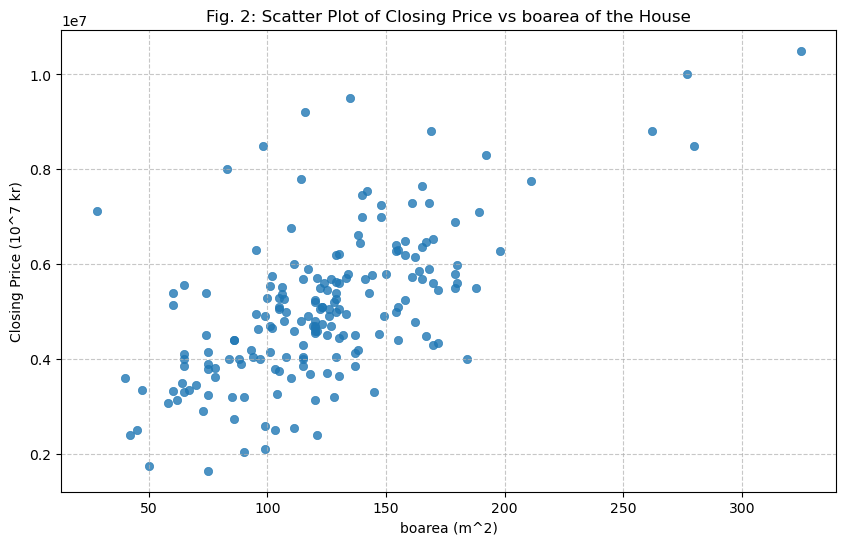

In [11]:
# get boarea
def extract_boarea(value):
    if isinstance(value, str):
        # replace ',' with '.'
        value = value.replace(',', '.')
        if '+' in value:
            # extract boarea from A + B
            boarea = value.split('+')[0]
            boarea = float(boarea)
            return boarea
        else:
            return float(value)
    elif isinstance(value, (int, float)):
        return float(value)
    else:
        return None

data['boarea (m^2)'] = data['Area (m^2)'].apply(extract_boarea)
data['Closing price (kr)'] = data['Closing price (kr)'].astype('int32')

plt.figure(figsize=(10, 6))
plt.scatter(data['boarea (m^2)'], data['Closing price (kr)'], alpha=0.8, linewidths=0.5)
plt.xlabel('boarea (m^2)')
plt.ylabel('Closing Price (10^7 kr)')
plt.title('Fig. 2: Scatter Plot of Closing Price vs boarea of the House')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## 2.4 scatter plot which colorize the observations by the number of rooms

Some entries have number of rooms with decimals, so we have to rewrite the decimal point, then plot a scatter plot based on the number of rooms.

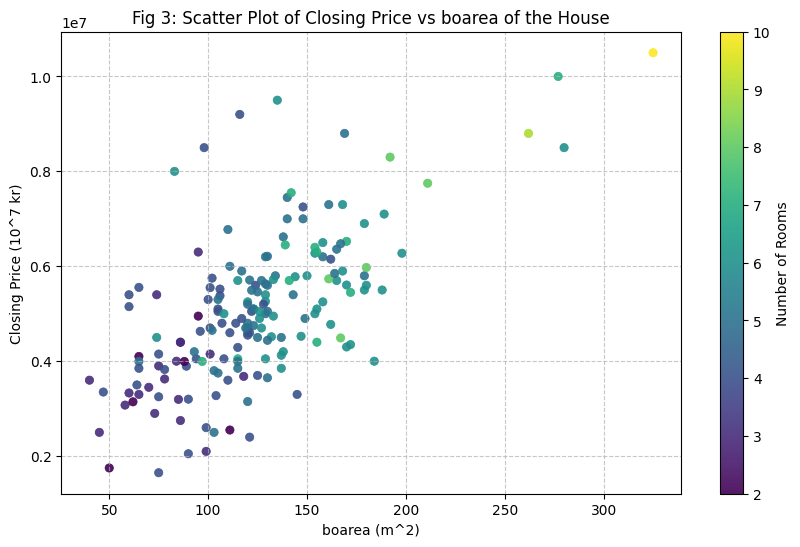

In [12]:
# colorize the plot based on the number of rooms
# change ',' to '.'
def convert_room(value) :
    if isinstance(value, str) :
        value = value.replace(',', '.')
        return float(value)
    elif isinstance(value, (int, float)):
        return float(value)
    else:
        return None

# convert the string to float
data['No. of rooms'] = data['No. of rooms'].apply(convert_room)

plt.figure(figsize=(10, 6))
sc = plt.scatter(data['boarea (m^2)'], data['Closing price (kr)'], c=data['No. of rooms'], cmap='viridis', alpha=0.9, linewidths=0.5)
plt.xlabel('boarea (m^2)')
plt.ylabel('Closing Price (10^7 kr)')
plt.title('Fig 3: Scatter Plot of Closing Price vs boarea of the House (Colored by Number of Rooms)')
plt.colorbar(sc, label='Number of Rooms')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## 2.5 Discuss shortly what the figures tell about the prices and the relationship between the different variables

### 2.5.1 histogram of the closing prices

Fig 1 tells that the closing prices of houses approximately follow a normal distribution where the mean value is around $5 * 10 ^ 6$ kr.

### 2.5.1 boarea vs Closing Price

Fig 2 tells that there is a positive linear correlation between boarea and closing price. Larger houses tend to have higher prices. Besides, most of the data points are in the range of 50 - 150 m² for boarea and 2 - 6 million for price.

### 2.5.2 borea vs Closing Price

Fig 3 tells that the number of rooms is positively correlated with the boarea. Houses with fewer rooms (darker colors) tend to have lower prices, while those with more rooms (lighter colors) are often in higher price and larger area ranges. Generally, larger houses also have more rooms. The distribution also indicates that as house area increases, the number of rooms also increases, and the closing price tends to rise as well.